In [1]:
import sys
sys.path.append("../")

import os
import psycopg2
import datetime
import psycopg2.extras
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from nayve_bayes.people_ensamble import *
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
## Reading DB credentials

dbname = os.environ['DBNAME']
dbport = os.environ['DBPORT']
dbhost = os.environ['DBHOST']
dbuser = os.environ['DBUSER']
dbpass = os.environ['DBPASS']

In [3]:
## Training and validation period

lim_inf_training = '2021-07-01'
lim_sup_training = '2021-07-31'
lim_inf_validation = '2021-08-01'
lim_sup_validation = '2021-08-31'

In [4]:
## Getting training data from Epi-PUMA DB

infected = [3] # covariable ID's 

sql = "SELECT date_occurrence, gridid_mun \
        FROM occurrence where covariable_id in ({0}) and date_occurrence >= '{1}' \
        and date_occurrence <= '{2}' and edad >= 60"\
        .format(','.join([str(strid) for strid in infected]), lim_inf_training, lim_sup_training)

engine = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(
    dbuser,
    dbpass,
    dbhost,
    dbport,
    dbname
))

df_train = pd.read_sql(sql, engine)
df_train.head()

,date_occurrence,gridid_mun
0,2021-07-01,15033
1,2021-07-01,09017
2,2021-07-01,09017
3,2021-07-01,09011
4,2021-07-01,09014


In [5]:
## Getting validation data

sql = "SELECT date_occurrence, gridid_mun \
        FROM occurrence where covariable_id in ({0}) and date_occurrence >= '{1}'\
        and date_occurrence <= '{2}' and edad >= 60"\
        .format(','.join([str(strid) for strid in infected]), lim_inf_validation, lim_sup_validation)

df_valid = pd.read_sql(sql, engine)
df_valid.head()

,date_occurrence,gridid_mun
0,2021-08-01,17009
1,2021-08-01,15012
2,2021-08-01,19046
3,2021-08-01,19046
4,2021-08-01,19046


In [6]:
## Processing training data

data_train = df_train.groupby(by='gridid_mun').count()
data_train = data_train.reset_index()
data_train = data_train.rename(columns={'date_occurrence': 'cases'})
data_train.head()

,gridid_mun,cases
0,01001,97
1,01003,1
2,01005,3
3,01006,2
4,01008,2


In [7]:
## Processing validation data

data_valid = df_valid.groupby(by='gridid_mun').count()
data_valid = data_valid.reset_index()
data_valid = data_valid.rename(columns={'date_occurrence': 'cases'})
data_valid.head()

,gridid_mun,cases
0,01001,323
1,01002,8
2,01003,13
3,01004,1
4,01005,15


In [8]:
## Getting occurrence covariable data

engine = create_engine('postgresql://{0}:{1}@{2}:{3}/{4}'.format(
    dbuser,
    dbpass,
    dbhost,
    dbport,
    'epi_puma_inegi_2020'
))

sql = "SELECT gridid_mun, covariable_id FROM occurrence"

df_covocc = pd.read_sql(sql, engine)
df_covocc.head()

,gridid_mun,covariable_id
0,01001,1308
1,01001,1297
2,01003,1032
3,01003,1060
4,01003,883


In [9]:
## Getting covariable data

sql = "SELECT id, name, code, interval FROM covariable"

df_cov = pd.read_sql(sql, engine)
df_cov.head()

,id,name,code,interval
0,14,Población femenina,POBFEM,50.5%:50.9%
1,25,Población masculina,POBMAS,48.4%:48.7%
2,37,Población de 0 a 2 años,P_0A2,5.31%:5.57%
3,48,Población femenina de 0 a 2 años,P_0A2_F,2.76%:2.96%
4,58,Población masculina de 0 a 2 años,P_0A2_M,2.82%:2.99%


In [10]:
## Getting total demographic group population

sql = "select gridid_mun, \"P_60YMAS\"*\"POBTOT\" as pob \
        from occurrence where covariable_id >= 1 and covariable_id <= 10;"

df_pob = pd.read_sql(sql, engine)
df_pob.head()

,gridid_mun,pob
0,01007,5264.0
1,01008,956.0
2,02001,53463.0
3,03002,6741.0
4,03003,37267.0


In [11]:
## Getting 100% of municipalities to train the model

data_pob_sample = df_pob.sample(frac=1)
data_pob_sample.shape

(2469, 2)

In [12]:
df_results_cov_training = get_results_covariable(data_train, df_covocc, df_cov, data_pob_sample)
df_results_cov_training.head()

,name,id,variable,Nx,Ncx,PCX,PC,Nc,N,epsilon,Nc_,Nc_x,P_C,P_CX,s0,score
0,Población femenina 50.5%:50.9%,14,POBFEM 50.5%:50.9%,1555403.0,2453,0.001577,0.00217,32856,15142976.0,-15.884704,15110120.0,1552950.0,0.99783,0.998423,-6.130986,-0.319613
1,Población masculina 48.4%:48.7%,25,POBMAS 48.4%:48.7%,1935677.0,4358,0.002251,0.00217,32856,15142976.0,2.442612,15110120.0,1931319.0,0.99783,0.997749,-6.130986,0.037041
2,Población de 0 a 2 años 5.31%:5.57%,37,P_0A2 5.31%:5.57%,855195.0,1335,0.001561,0.00217,32856,15142976.0,-12.097214,15110120.0,853860.0,0.99783,0.998439,-6.130986,-0.329847
3,Población femenina de 0 a 2 años 2.76%:2.96%,48,P_0A2_F 2.76%:2.96%,730453.0,1038,0.001421,0.00217,32856,15142976.0,-13.751939,15110120.0,729415.0,0.99783,0.998579,-6.130986,-0.423957
4,Población masculina de 0 a 2 años 2.82%:2.99%,58,P_0A2_M 2.82%:2.99%,766397.0,854,0.001114,0.00217,32856,15142976.0,-19.857273,15110120.0,765543.0,0.99783,0.998886,-6.130986,-0.667418


In [13]:
df_cell_training = get_results_cell(df_results_cov_training, data_train, df_covocc, data_pob_sample)
df_cell_training.head(20)

,score,gridid_mun,pob,cases,p,percentile
0,60.970293,09017,78964.0,689.0,0.006029,20
1,60.297317,09005,203469.0,1235.0,0.006029,20
2,57.832409,09006,70907.0,518.0,0.006029,20
3,56.706359,09012,108894.0,731.0,0.006029,20
4,55.666658,09007,262064.0,1235.0,0.006029,20
5,53.576126,09010,122319.0,696.0,0.006029,20
6,53.159005,09003,126592.0,397.0,0.005250,19
7,53.042644,09008,38073.0,243.0,0.005250,19
8,50.980884,09015,93809.0,492.0,0.005250,19
9,47.342989,09002,78650.0,380.0,0.005250,19


In [14]:
## Getting 100% of municipalities to train the model

data_pob_sample_valid = df_pob.sample(frac=0.7)
data_pob_sample_valid.shape

(1728, 2)

In [15]:
cells_no_validation = data_pob_sample_valid['gridid_mun'].tolist()

In [16]:
data_valid_sample = data_valid[data_valid['gridid_mun'].isin(cells_no_validation)]
data_valid_sample.shape

(1216, 2)

In [17]:
df_covocc_sample_valid = df_covocc[df_covocc['gridid_mun'].isin(cells_no_validation)]
df_covocc_sample_valid.shape

(381888, 2)

In [18]:
df_results_cov_validation = get_results_covariable(data_valid_sample, df_covocc_sample_valid, df_cov, data_pob_sample_valid)
df_results_cov_validation.head()

,name,id,variable,Nx,Ncx,PCX,PC,Nc,N,epsilon,Nc_,Nc_x,P_C,P_CX,s0,score
0,Población femenina 50.5%:50.9%,14,POBFEM 50.5%:50.9%,1087140.0,3409,0.003136,0.003525,37603,10666186.0,-6.855223,10628583.0,1083731.0,0.996475,0.996864,-5.644218,-0.117526
1,Población masculina 48.4%:48.7%,25,POBMAS 48.4%:48.7%,1471965.0,5006,0.003401,0.003525,37603,10666186.0,-2.549364,10628583.0,1466959.0,0.996475,0.996599,-5.644218,-0.036091
2,Población de 0 a 2 años 5.31%:5.57%,37,P_0A2 5.31%:5.57%,614821.0,2191,0.003564,0.003525,37603,10666186.0,0.505340,10628583.0,612630.0,0.996475,0.996436,-5.644218,0.010817
3,Población femenina de 0 a 2 años 2.76%:2.96%,48,P_0A2_F 2.76%:2.96%,536780.0,1177,0.002193,0.003525,37603,10666186.0,-16.474124,10628583.0,535603.0,0.996475,0.997807,-5.644218,-0.476202
4,Población masculina de 0 a 2 años 2.82%:2.99%,58,P_0A2_M 2.82%:2.99%,575809.0,1224,0.002126,0.003525,37603,10666186.0,-17.920303,10628583.0,574585.0,0.996475,0.997874,-5.644218,-0.507302


In [19]:
df_cell_validation = get_results_cell(df_results_cov_validation, data_valid_sample, df_covocc_sample_valid, data_pob_sample_valid)
df_cell_validation.head(20)

,score,gridid_mun,pob,cases,p,percentile
0,33.811130,09005,203469.0,1329.0,0.006474,20
1,32.573614,09012,108894.0,823.0,0.006474,20
2,32.275236,09007,262064.0,1567.0,0.006474,20
3,30.673715,09010,122319.0,753.0,0.006263,19
4,29.661674,09008,38073.0,211.0,0.006263,19
5,29.082342,27004,78902.0,1075.0,0.006263,19
6,25.298067,09013,60987.0,528.0,0.006263,19
7,23.963476,15058,164512.0,649.0,0.006263,19
8,22.952827,09003,126592.0,488.0,0.006263,19
9,22.531404,17007,64606.0,212.0,0.004894,18


In [20]:
df_cell_validation.shape

(1728, 6)

In [21]:
#df_cell_validation_sample = df_cell_validation.sample(frac=0.7)
validation_cells_gridids = df_cell_validation['gridid_mun'].tolist()
df = df_cell_training[df_cell_training['gridid_mun'].isin(validation_cells_gridids)]

df = df[['gridid_mun', 'p']].rename(columns={'p': 'p_training'})\
        .merge(df_cell_validation[['gridid_mun', 'p']].rename(columns={'p': 'p_validation'}), on='gridid_mun')
df = df.sort_values('gridid_mun')
df = df.reset_index(drop=True)
df.head()

,gridid_mun,p_training,p_validation
0,01001,0.001324,0.004314
1,01002,0.000827,0.001975
2,01004,0.001003,0.001803
3,01005,0.001567,0.002739
4,01006,0.000810,0.002215


In [22]:
training_probas = df['p_training'].to_numpy()
validation_probas = df['p_validation'].to_numpy()
reg = LinearRegression()
reg.fit(training_probas.reshape(-1, 1), validation_probas)

LinearRegression()

In [23]:
df_cells_to_predict = df_cell_training[~(df_cell_training['gridid_mun'].isin(validation_cells_gridids))][['gridid_mun', 'p']]
df_cells_to_predict = df_cells_to_predict.sort_values('gridid_mun')
df_cells_to_predict = df_cells_to_predict.rename(columns={'p': 'p_training'})
df_cells_to_predict = df_cells_to_predict.reset_index(drop=True)
df_cells_to_predict.head()

,gridid_mun,p_training
0,01003,0.000810
1,01009,0.000827
2,01010,0.000827
3,02002,0.001961
4,02003,0.001324


In [24]:
p_predicted_validation = reg.predict(df_cells_to_predict['p_training'].to_numpy().reshape(-1, 1))

In [25]:
df_cells_to_predict['p_predicted_validation'] = pd.Series(p_predicted_validation)
df_cells_to_predict = df_cells_to_predict.merge(df_pob[['gridid_mun', 'pob']], how='left', on='gridid_mun')
df_cells_to_predict = df_cells_to_predict.merge(data_valid[['gridid_mun', 'cases']], how='left', on='gridid_mun')
df_cells_to_predict = df_cells_to_predict.rename(columns={'cases': 'cases_validation'})
df_cells_to_predict['cases_predicted_validation'] = df_cells_to_predict['p_predicted_validation']*df_cells_to_predict['pob']
df_cells_to_predict['cases_validation'] = df_cells_to_predict['cases_validation'].fillna(0)
df_cells_to_predict = df_cells_to_predict.reset_index()
df_cells_to_predict.head()

,index,gridid_mun,p_training,p_predicted_validation,pob,cases_validation,cases_predicted_validation
0,0,01003,0.000810,0.001834,7829.0,13.0,14.362166
1,1,01009,0.000827,0.001855,2158.0,5.0,4.003403
2,2,01010,0.000827,0.001855,1988.0,0.0,3.688029
3,3,02002,0.001961,0.003223,122934.0,156.0,396.248339
4,4,02003,0.001324,0.002455,11535.0,8.0,28.321586


Text(0, 0.5, 'Probability Validation Period')

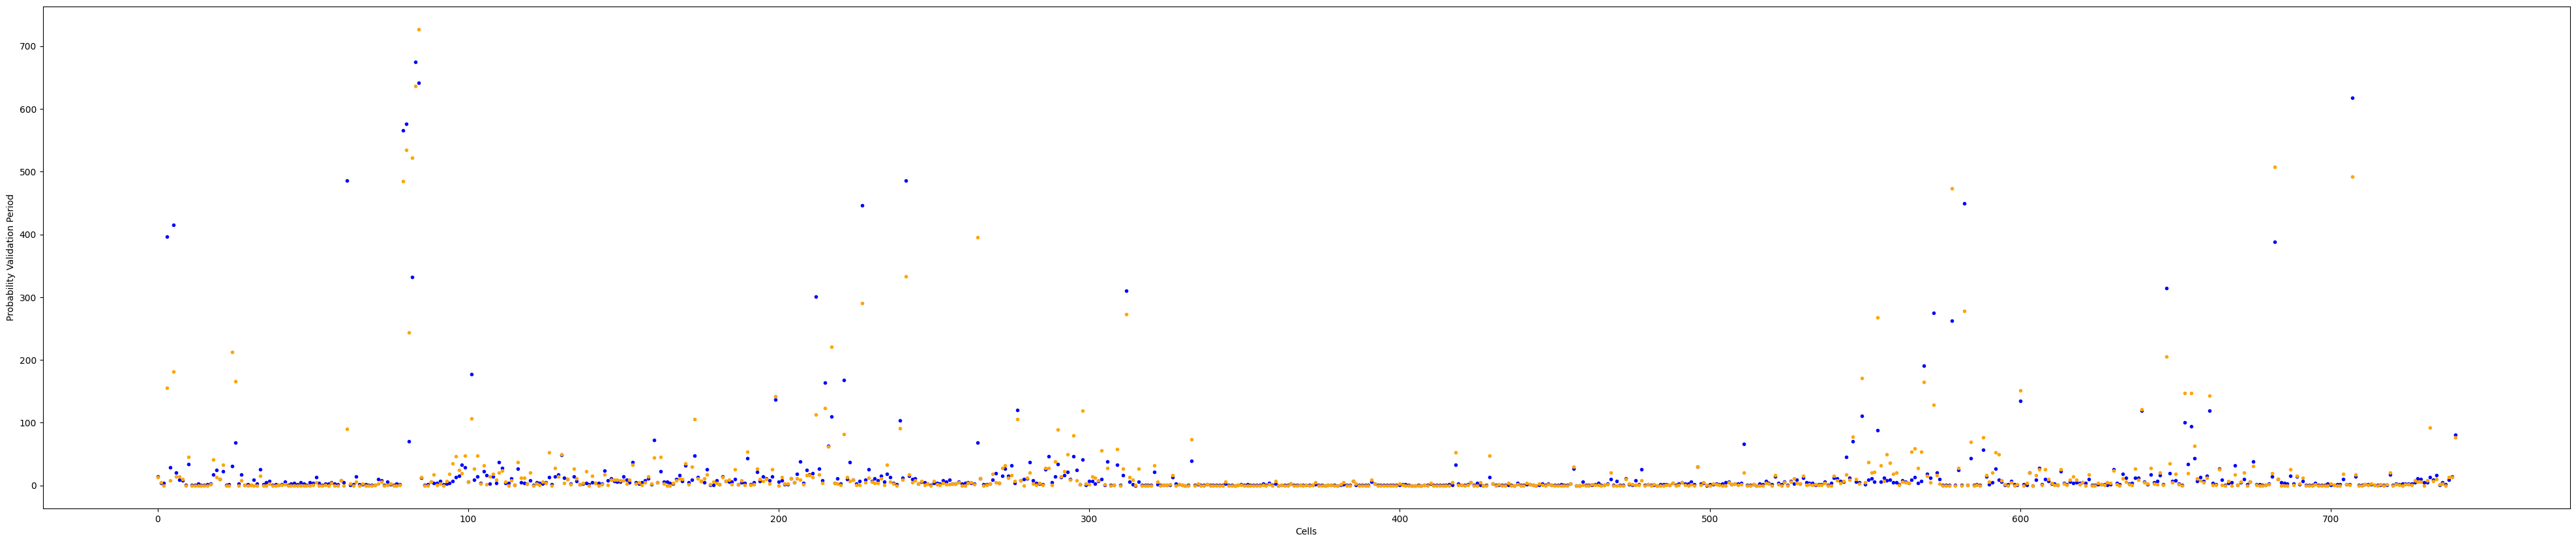

In [26]:
plt.figure(figsize=(50, 10))
plt.scatter(df_cells_to_predict.index.tolist(), 
            df_cells_to_predict['cases_predicted_validation'].tolist(), 
            color='blue', marker='.')
plt.scatter(df_cells_to_predict.index.tolist(), 
            df_cells_to_predict['cases_validation'].tolist(), 
            color='orange', marker='.')
plt.xlabel('Cells')
plt.ylabel('Probability Validation Period')

Text(0, 0.5, 'Predicted Cases Validation Period')

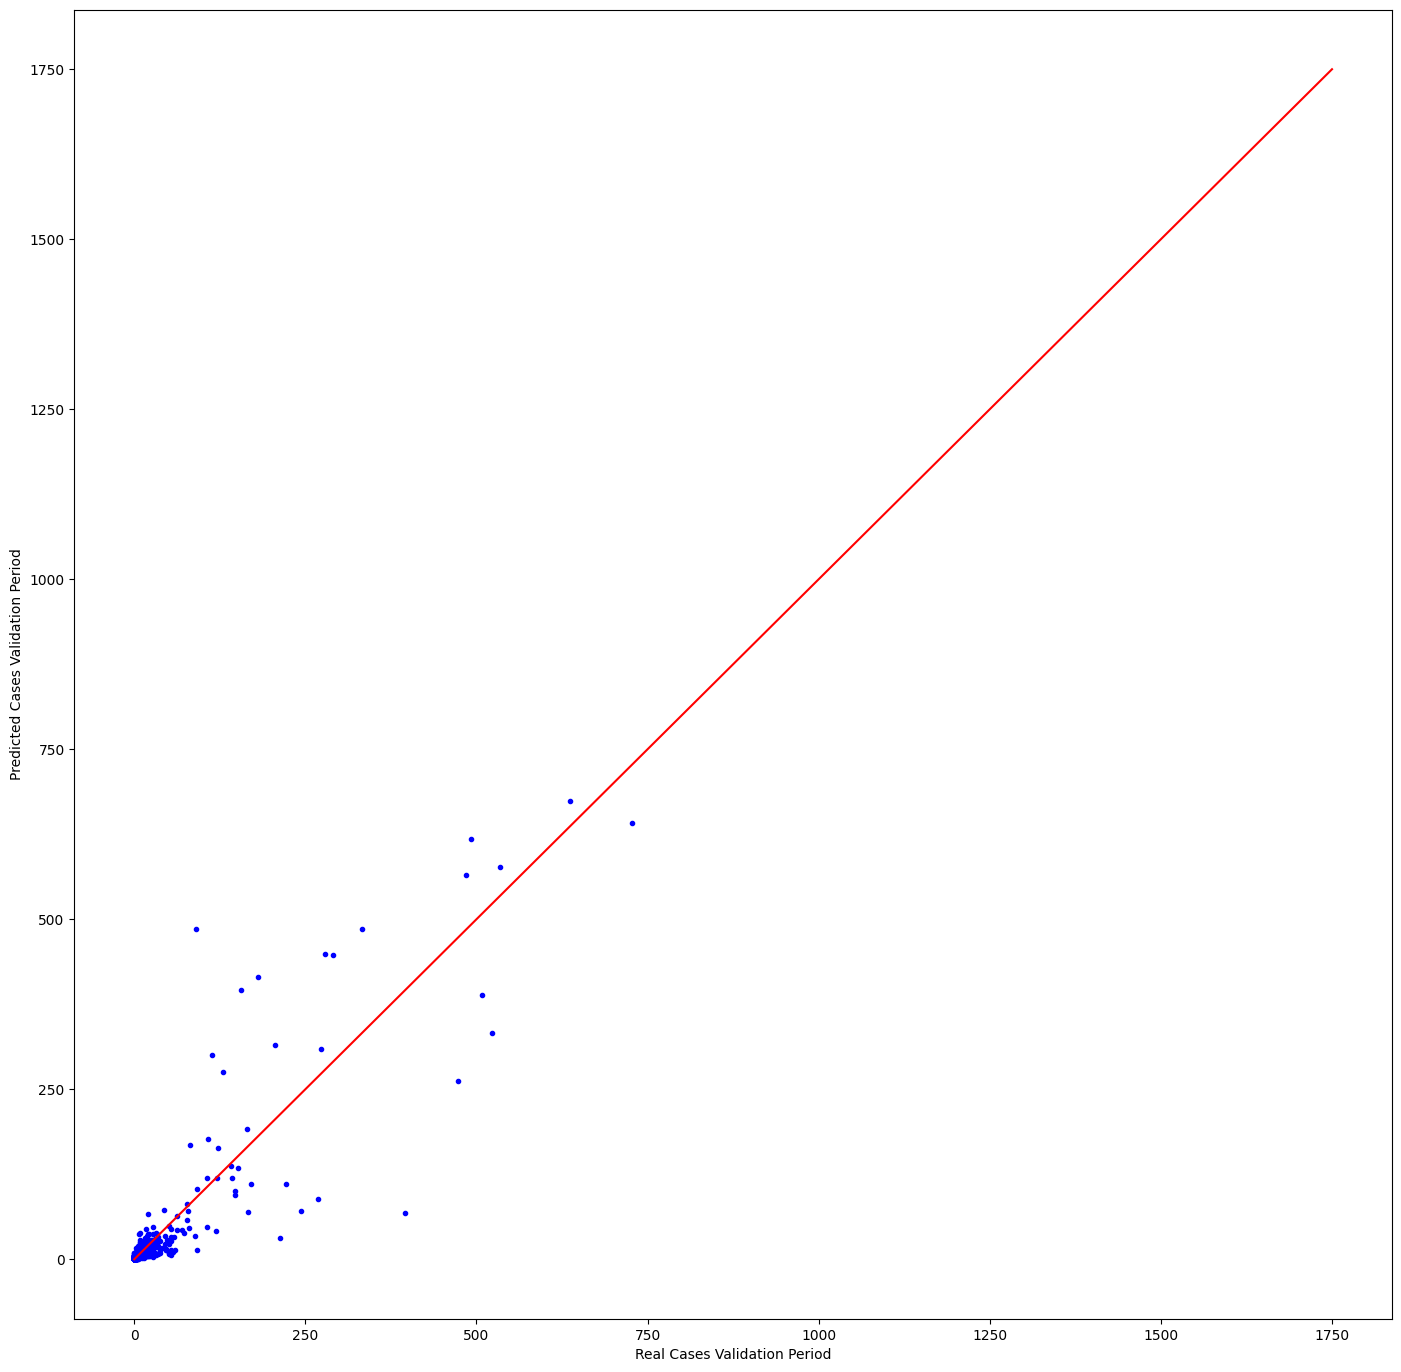

In [27]:
plt.figure(figsize=(17, 17))
plt.plot([0, 1750], [0, 1750], color='red')
plt.scatter(df_cells_to_predict['cases_validation'].tolist(), 
            df_cells_to_predict['cases_predicted_validation'].tolist(), 
            color='blue', marker='.')
plt.xlabel('Real Cases Validation Period')
plt.ylabel('Predicted Cases Validation Period')

In [28]:
r2 = r2_score(
    df_cells_to_predict['cases_validation'].tolist(), 
    df_cells_to_predict['cases_predicted_validation'].tolist())
r2

0.7507708992219273